# Downloading Dataset

In [1]:
import os

# Create the .kaggle directory if it doesn't exist
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

# Move kaggle.json to the .kaggle directory
# Make sure you have uploaded kaggle.json to your Colab session storage first
!mv kaggle.json /root/.kaggle/

# Set permissions for the kaggle.json filey
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset
!unzip dog-and-cat-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5499.jpg  
  inflating: PetImages/Dog/55.jpg    
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   

# Importing Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping

In [4]:
import os
from PIL import Image

def remove_corrupted_images(directory):
    num_deleted = 0
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()
            except:
                os.remove(path)
                num_deleted += 1
    print("Deleted images:", num_deleted)

remove_corrupted_images("PetImages")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Deleted images: 0


# Spliting data into train and test

In [5]:
# image dataset is big and its difficult to load it on RAM and train the model
# Solution :- Generators

# Generators :- Load images in the RAM batch wise and train it batch wise.

train_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

train_ds = train_ds.ignore_errors()

val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


# Data Agumentation layer

In [6]:
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Building a modal

In [7]:
model = Sequential([
    Input(shape = (256, 256, 3)),

    data_augmentation,
    layers.Rescaling(1./255),

    Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(54, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         6,966 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,893 (56.64 MB)

 Trainable params: 14,846,445 (56.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ]
)

In [10]:
callbacks = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
)

In [11]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
    618/Unknown 107s 157ms/step - accuracy: 0.5428 - loss: 2.6776 - precision: 0.5467 - recall: 0.5465

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


618/618 ━━━━━━━━━━━━━━━━━━━━ 115s 171ms/step - accuracy: 0.5428 - loss: 2.6755 - precision: 0.5468 - recall: 0.5464 - val_accuracy: 0.6267 - val_loss: 0.6268 - val_precision: 0.7800 - val_recall: 0.3760
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 105s 169ms/step - accuracy: 0.6258 - loss: 0.6373 - precision: 0.6678 - recall: 0.5134 - val_accuracy: 0.6861 - val_loss: 0.5890 - val_precision: 0.7466 - val_recall: 0.5845
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 106s 172ms/step - accuracy: 0.6791 - loss: 0.5919 - precision: 0.7099 - recall: 0.6135 - val_accuracy: 0.6269 - val_loss: 1.5553 - val_precision: 0.7693 - val_recall: 0.3862
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 106s 171ms/step - accuracy: 0.6902 - loss: 0.5910 - precision: 0.7133 - recall: 0.6422 - val_accuracy: 0.7147 - val_loss: 0.5475 - val_precision: 0.6846 - val_recall: 0.8196
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 106s 172ms/step - accuracy: 0.7201 - loss: 0.5522 - precision: 0.7374 - recall: 0.6897 - val_accuracy: 0.7493 - val

# Plotting accuracy and validation accuracy



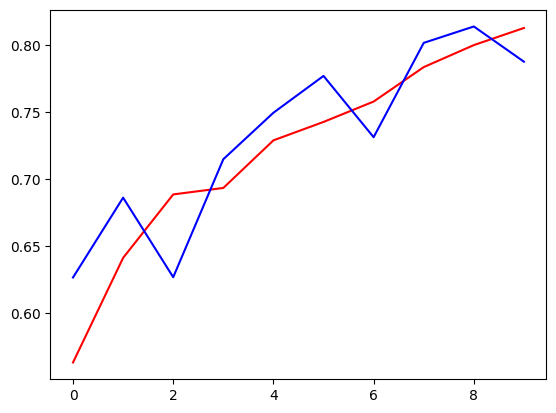

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], c='r')
plt.plot(history.history['val_accuracy'], c='b')
plt.show()

# Plotting Loss and validation loss

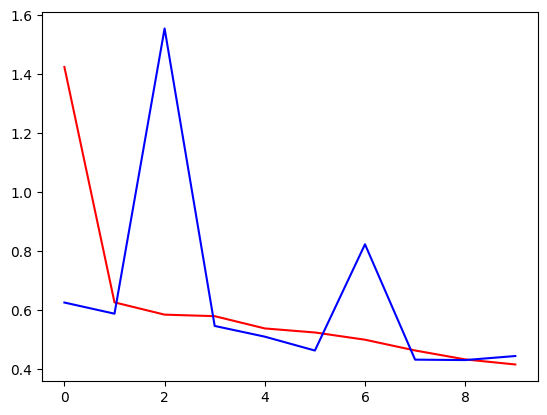

In [13]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='b')
plt.show()

# Prediction

In [14]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int)   # threshold = 0.5

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluation Metrics

In [15]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(val_ds)

print(f"Test Loss      : {test_loss:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Test Precision : {test_precision:.4f}")
print(f"Test Recall    : {test_recall:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7838 - loss: 0.4503 - precision: 0.8517 - recall: 0.7053
Test Loss      : 0.4456
Test Accuracy  : 0.7874
Test Precision : 0.8594
Test Recall    : 0.6984


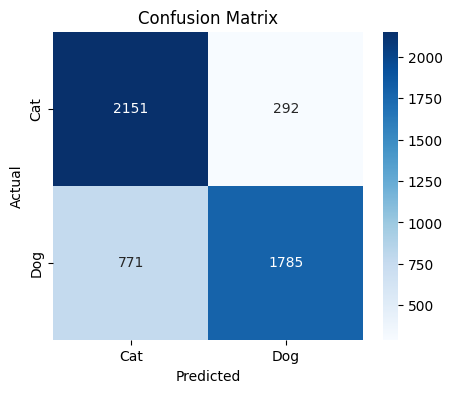

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=['Cat', 'Dog']
))

              precision    recall  f1-score   support

         Cat       0.74      0.88      0.80      2443
         Dog       0.86      0.70      0.77      2556

    accuracy                           0.79      4999
   macro avg       0.80      0.79      0.79      4999
weighted avg       0.80      0.79      0.79      4999



In [18]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

F1 Score: 0.7705590330239586
